## CarND Vehicle Detection Project 5

In [2]:
#Import libraries
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

In [3]:
# Load the training data
car_images = glob.glob('vehicles/**/*.png')
noncar_images = glob.glob('non-vehicles/**/*.png')
print('There are a total of' ,len(car_images), 'car images and', len(noncar_images),'non-car images')

There are a total of 8792 car images and 8968 non-car images


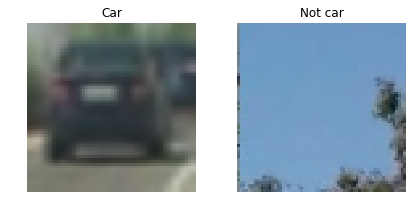

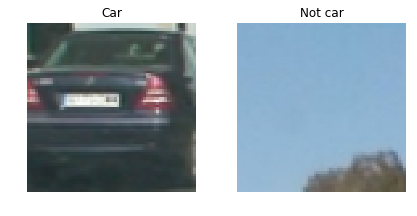

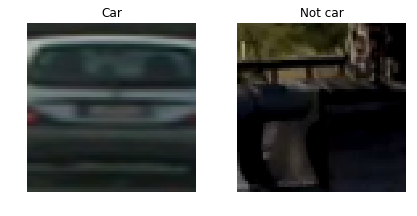

In [4]:
#Visualization of the dataset
#Print three images of each dataset

for i in range(0,3000,1000):
    #Read data
    carimg=mpimg.imread(car_images[i])
    noncarimg=mpimg.imread(noncar_images[i])
    f,(ax1,ax2) = plt.subplots(1, 2)
    plt.tight_layout()
    ax1.imshow(carimg)
    ax1.axis('off')
    ax1.set_title('Car')
    ax2.imshow(noncarimg)
    ax2.axis('off')
    ax2.set_title('Not car')

C:\Users\tugru\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


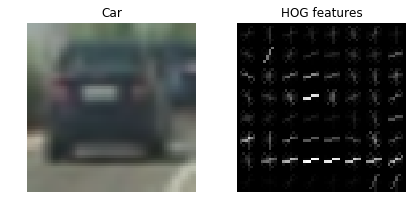

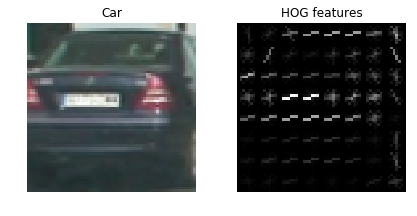

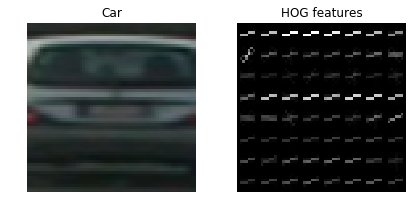

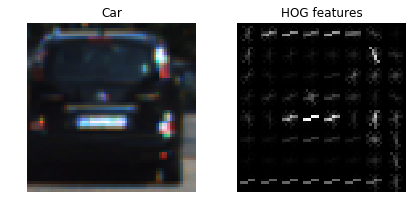

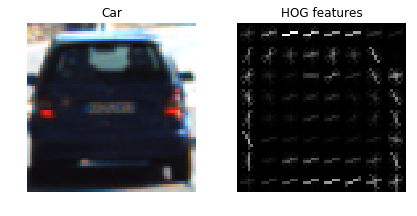

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

#Visualizing HOG Features
for i in range(0,5000,1000):
    carimg=mpimg.imread(car_images[i])
    _,car_hog=get_hog_features(carimg[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
        
    f,(ax1,ax2) = plt.subplots(1, 2)
    plt.tight_layout()
    ax1.imshow(carimg)
    ax1.axis('off')
    ax1.set_title('Car')
    ax2.imshow(car_hog,cmap='gray')
    ax2.axis('off')
    ax2.set_title('HOG features')

    
    


In [8]:
#Helper functions from classroom codes
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,spatial_feat=True, hist_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        temp_features = []
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS': 
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            temp_features.append(spatial_features)
        
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            temp_features.append(hist_features)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        temp_features.append(hog_features)
        features.append(np.concatenate(temp_features))
    # Return list of feature vectors
    return np.asarray(features)

### Train and test the HOG SVC

In [10]:
#sample_size = 1000
#cars = car_images[0:sample_size]
#noncars = noncar_images[0:sample_size]

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True 
hist_feat = True

t=time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

#Features should be scaled to zero mean and unit variance before training the classifier.
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

C:\Users\tugru\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


71.53 Seconds to extract HOG features...
Using: 10 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 9144
6.03 Seconds to train SVC...
Test Accuracy of SVC =  0.9927
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  1.  1.  0.  0.]
0.00197 Seconds to predict 10 labels with SVC


### Find cars and draw boxes

C:\Users\tugru\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(-0.5, 1279.5, 719.5, -0.5)

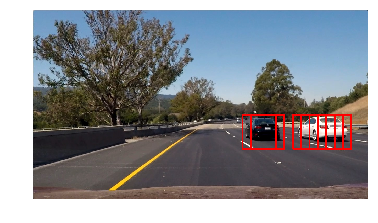

In [13]:
# Define a single function that can extract features using hog sub-sampling and make predictions
#Thanks to https://github.com/ILYAmLV/
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255 #If you read jpg divide by 255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append(((xbox_left, ytop_draw+ystart), 
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return bbox_list

def draw_boxes(img, bboxes, color=(255,0,0), thick=6, random_color=False):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Random color code copied from jeremy-shannon
        if random_color == True:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

ystart = 400
ystop = 656
scale = 2

img = mpimg.imread('test_images/test6.jpg')    
bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img=draw_boxes(img,bbox_list)

plt.imshow(out_img)
plt.axis('off')

### Add Heat and remove false positives

C:\Users\tugru\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


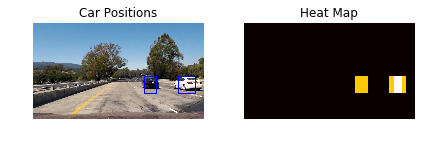

In [15]:
from scipy.ndimage.measurements import label

#Classroom functions
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


# Read the same image
image = mpimg.imread('test_images/test1.jpg')
bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,bbox_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.axis('off')
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.axis('off')
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


C:\Users\tugru\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


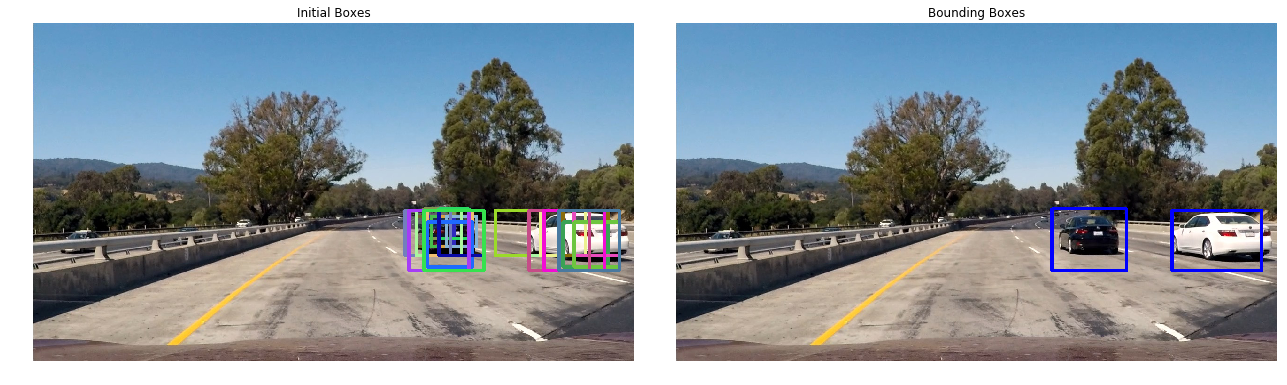

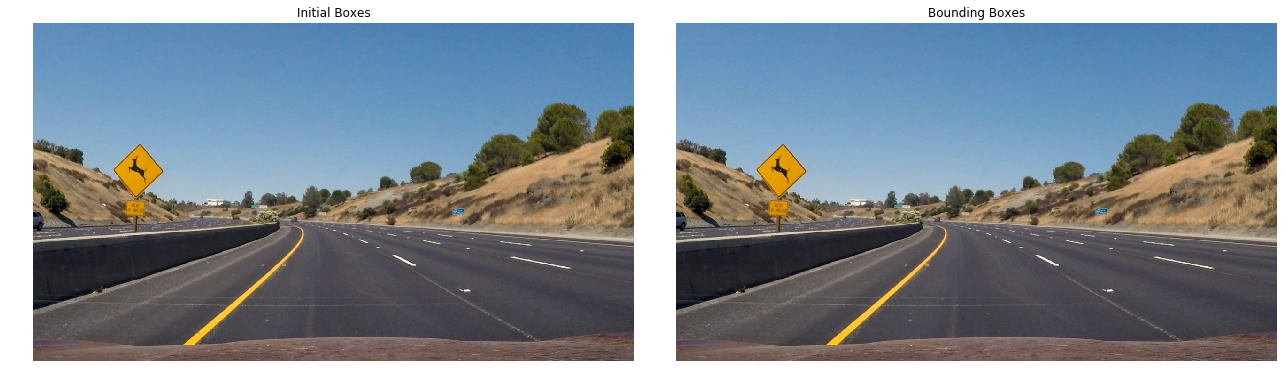

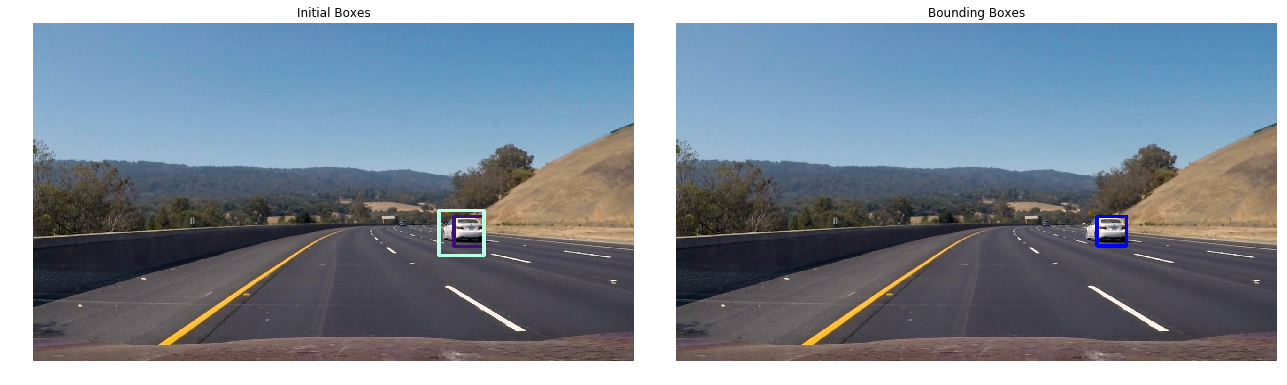

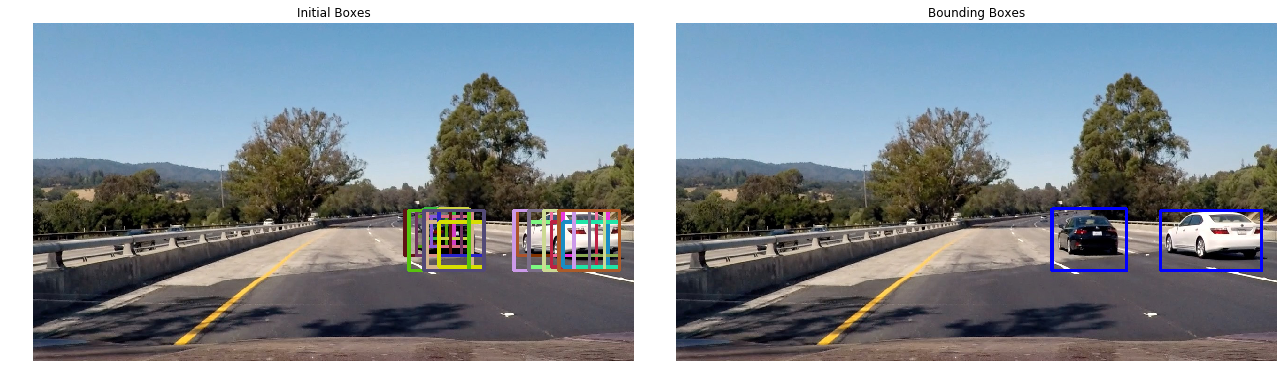

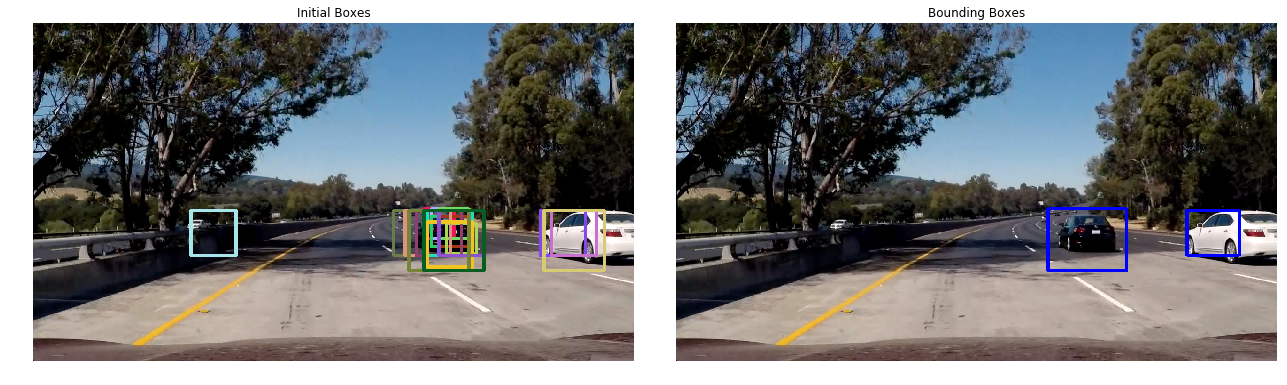

In [17]:
for i in range(1,6):
    
    fname = 'test_images/test{}.jpg'.format(i)
    img = mpimg.imread(fname)
    

    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    
    bbox_list = []
    
    
    ystart = 380
    ystop = 550
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 656
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
   
    bbox_list = [item for sublist in bbox_list for item in sublist] #From https://github.com/jeremy-shannon/CarND-Vehicle-Detection/blob/master/vehicle_detection_project.ipynb
    
    out_img = draw_boxes(img, bbox_list, random_color=True)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 1)  #Optimize threshold value

    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(out_img)
    ax1.set_title('Initial Boxes')
    ax1.axis('off')
    ax2.imshow(new_img)
    ax2.set_title('Bounding Boxes')
    ax2.axis('off')

### Pipeline function

In [18]:
def process_image(img):

    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    
    bbox_list = []
    
    ystart = 380
    ystop = 550
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 656
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 1)  

    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return new_img

In [25]:
from moviepy.editor import VideoFileClip

test_output = "test_output.mp4"
clip = VideoFileClip("test_video.mp4")
test_clip = clip.fl_image(process_image)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:32<00:00,  1.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

Wall time: 33.5 s


In [20]:
from moviepy.editor import VideoFileClip

test_output = "project_output.mp4"
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [21:25<00:00,  1.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

Wall time: 21min 26s
